In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.0 MB/s 
     |████████████████████████████████| 9.8 MB 25.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [3]:
df1 = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv")
del df1['daily_vaccinations_raw']
df1.head()

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003


In [4]:
df = df1[['date', 'location', 'iso_code', 'people_vaccinated_per_hundred']]
print(df.shape)
df = df.dropna()
print(df.shape)
print(df['date'].isnull().values.any())

(67358, 4)
(36352, 4)
False


In [5]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df = df.set_index(['date'])
print(df)

               location iso_code  people_vaccinated_per_hundred
date                                                           
2021-02-22  Afghanistan      AFG                           0.00
2021-02-28  Afghanistan      AFG                           0.02
2021-03-16  Afghanistan      AFG                           0.14
2021-04-07  Afghanistan      AFG                           0.30
2021-04-22  Afghanistan      AFG                           0.60
...                 ...      ...                            ...
2021-12-04     Zimbabwe      ZWE                          25.62
2021-12-05     Zimbabwe      ZWE                          25.68
2021-12-06     Zimbabwe      ZWE                          25.73
2021-12-07     Zimbabwe      ZWE                          25.82
2021-12-08     Zimbabwe      ZWE                          25.90

[36352 rows x 3 columns]


In [6]:
df = df.sort_values('location')
india = df.loc[df['location'] == 'India']
idf = india.sort_values('people_vaccinated_per_hundred')
idf

,location,iso_code,people_vaccinated_per_hundred
date,,,
2021-01-15,India,IND,0.00
2021-01-16,India,IND,0.01
2021-01-17,India,IND,0.02
2021-01-18,India,IND,0.03
2021-01-19,India,IND,0.05
...,...,...,...
2021-12-05,India,IND,57.51
2021-12-06,India,IND,57.62
2021-12-07,India,IND,57.80


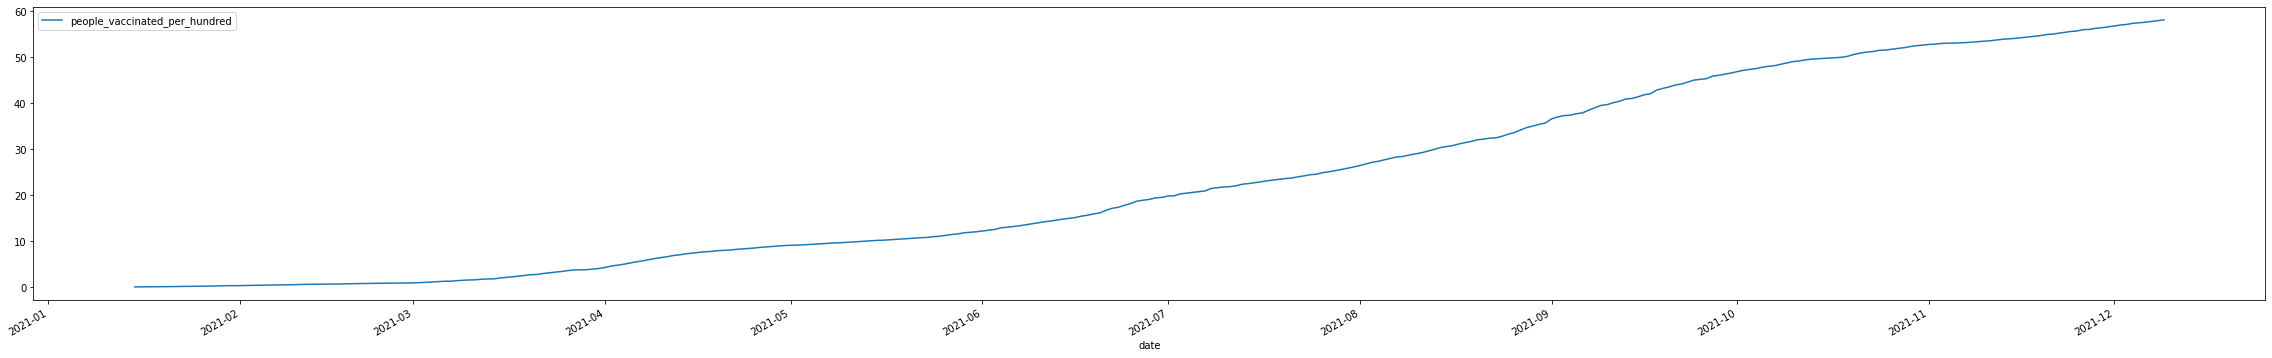

In [7]:
idf.plot(figsize=(40, 6))
plt.show()

In [8]:
val = idf['people_vaccinated_per_hundred'].values

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsap

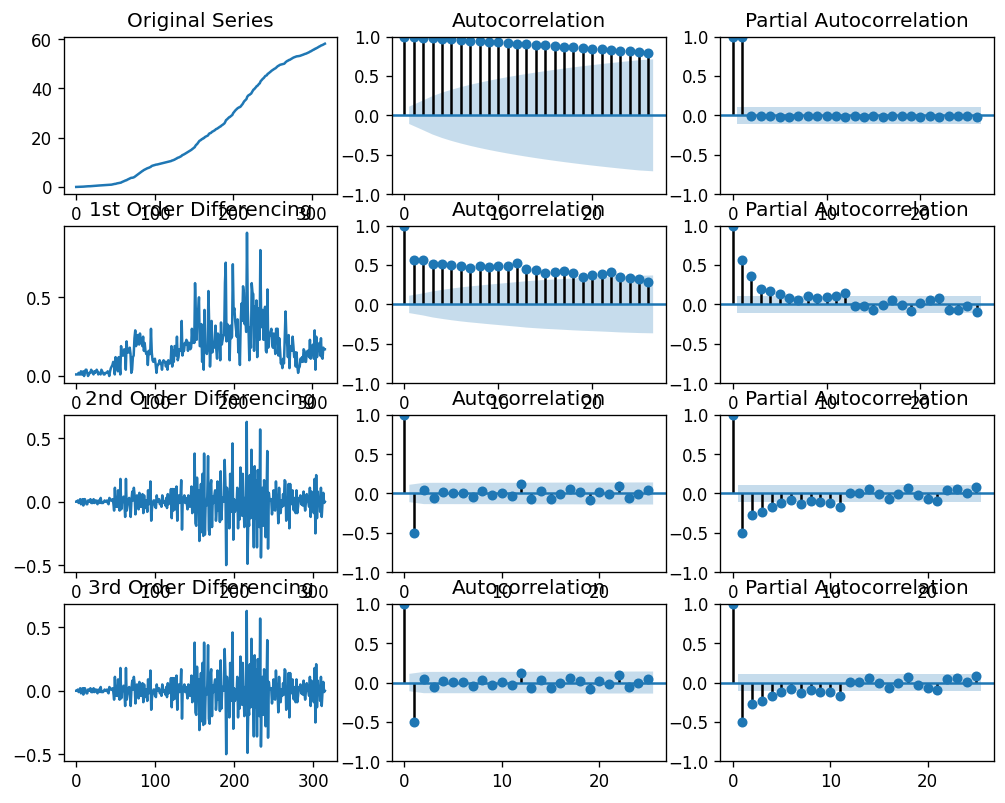

In [9]:
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(4, 3, sharex=False)
axes[0, 0].plot(val); axes[0, 0].set_title('Original Series')
plot_acf(val, ax=axes[0, 1])
plot_pacf(val, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(np.diff(val)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(val), ax=axes[1, 1])
plot_pacf(np.diff(val), ax=axes[1, 2])
diffval = np.diff(val)

# 2nd Differencing
axes[2, 0].plot(np.diff(diffval)); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(diffval), ax=axes[2, 1])
plot_pacf(np.diff(diffval), ax=axes[2, 2])
diffv = np.diff(diffval)

# 3rd Differencing
axes[3, 0].plot(np.diff(diffval)); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(np.diff(diffval), ax=axes[3, 1])
plot_pacf(np.diff(diffval), ax=axes[3, 2])
diffv = np.diff(diffval)


In [10]:
model = pm.auto_arima(val, start_p=1, start_q=1,
test='adf', # use adftest to find optimal 'd'
max_p=10, max_q=2, # maximum p and q
m=1, # frequency of series
d=None, # let model determine 'd'
seasonal=False, # No Seasonality
start_P=0,
D=0,
trace=True,
error_action='ignore',
suppress_warnings=True,
stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-515.105, Time=0.40 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-359.703, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-448.225, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-516.862, Time=0.40 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-361.699, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-515.077, Time=0.32 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-513.339, Time=0.65 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-518.620, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-516.851, Time=0.14 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-516.825, Time=0.13 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-450.212, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-515.102, Time=0.36 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 2.726 seconds
                               SARIMAX Results                                
Dep. Vari

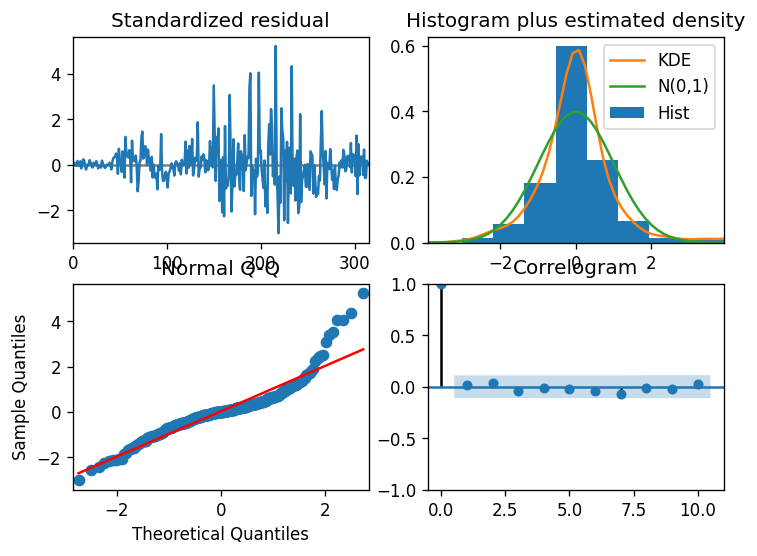

In [11]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

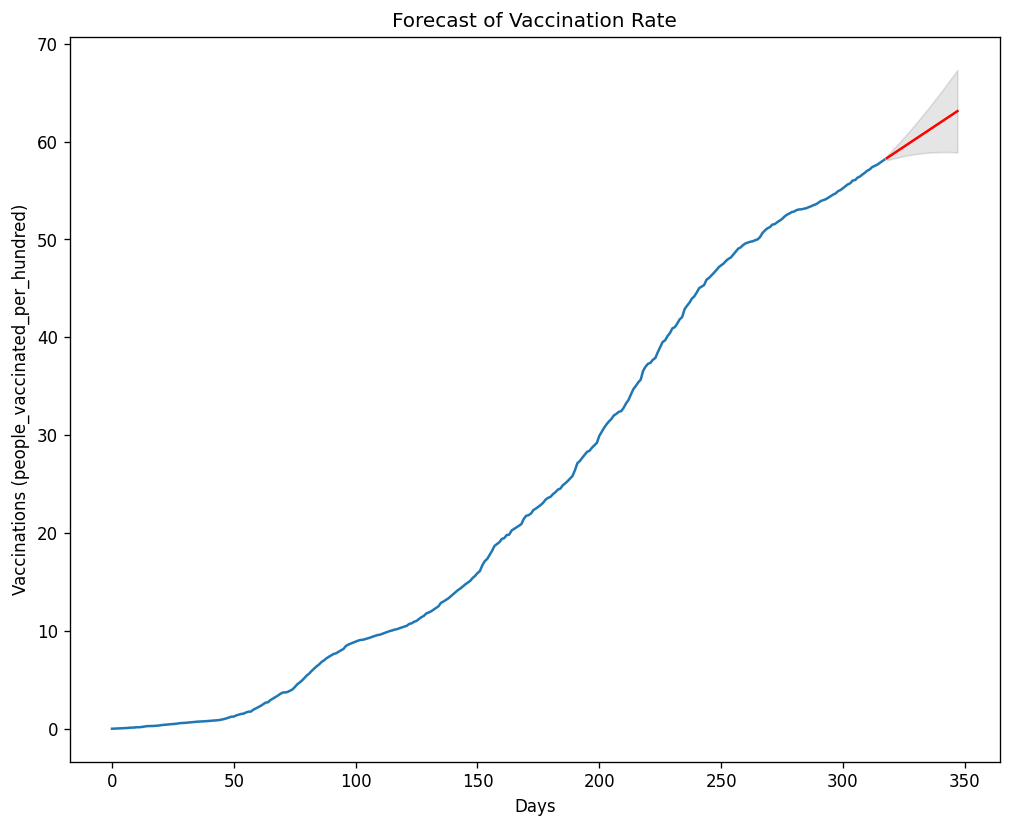

In [12]:
# Forecast
n_periods = 30
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(val), len(val)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(val)
plt.xlabel('Days')
plt.ylabel('Vaccinations (people_vaccinated_per_hundred)')
plt.plot(fc_series, color='red')
plt.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=.10)
plt.title("Forecast of Vaccination Rate")
plt.show()